In [1]:
import pandas as pd
import numpy as np
from itertools import product
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import category_encoders as ce
import warnings
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 160)
pd.set_option('display.max_colwidth', 40)
warnings.filterwarnings("ignore")

path = 'data/'

In [3]:
test = pd.read_csv(path+'test.csv')
test.sample(5)

,ID,shop_id,item_id
56347,56347,25,6928
1704,1704,5,2883
70535,70535,24,9389
180276,180276,38,12232
130215,130215,47,17469


**Preparing Item/Category Information**

In [5]:
categories = pd.read_csv(path+'item_categories.csv')
pd.DataFrame(categories.item_category_name.values.reshape(-1, 4))

,0,1,2,3
0,PC - Гарнитуры/Наушники,Аксессуары - PS2,Аксессуары - PS3,Аксессуары - PS4
1,Аксессуары - PSP,Аксессуары - PSVita,Аксессуары - XBOX 360,Аксессуары - XBOX ONE
2,Билеты (Цифра),Доставка товара,Игровые консоли - PS2,Игровые консоли - PS3
3,Игровые консоли - PS4,Игровые консоли - PSP,Игровые консоли - PSVita,Игровые консоли - XBOX 360
4,Игровые консоли - XBOX ONE,Игровые консоли - Прочие,Игры - PS2,Игры - PS3
5,Игры - PS4,Игры - PSP,Игры - PSVita,Игры - XBOX 360
6,Игры - XBOX ONE,Игры - Аксессуары для игр,Игры Android - Цифра,Игры MAC - Цифра
7,Игры PC - Дополнительные издания,Игры PC - Коллекционные издания,Игры PC - Стандартные издания,Игры PC - Цифра
8,"Карты оплаты (Кино, Музыка, Игры)",Карты оплаты - Live!,Карты оплаты - Live! (Цифра),Карты оплаты - PSN
9,Карты оплаты - Windows (Цифра),Кино - Blu-Ray,Кино - Blu-Ray 3D,Кино - Blu-Ray 4K


In [16]:
#create broader category groupings
categories['group_name'] = categories['item_category_name'].str.extract(r'(^[\w\s]*)')
categories['group_name'] = categories['group_name'].str.strip()
#label encode group names
categories['group_id']  = le.fit_transform(categories.group_name.values)
categories.sample(5)

,item_category_name,item_category_id,group_name,group_id
31,Игры PC - Цифра,31,Игры PC,8
38,Кино - Blu-Ray 3D,38,Кино,10
63,Подарки - Мягкие игрушки,63,Подарки,13
41,Кино - Коллекционное,41,Кино,10
54,Книги - Цифра,54,Книги,11


create n-gramms features

In [7]:
#load items
items = pd.read_csv(path+'items.csv')

#clean item_name
items['item_name'] = items['item_name'].str.lower()
items['item_name'] = items['item_name'].str.replace('.', '')
for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b',
          r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',  
          r'\bto\b', r'\bwith\b' , r'\byo\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ')
items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ')

#extract first n characters of name
items['item_name_no_space'] = items['item_name'].str.replace(' ', '')
items['item_name_first4'] = [x[:4] for x in items['item_name_no_space']]
items['item_name_first6'] = [x[:6] for x in items['item_name_no_space']]
items['item_name_first11'] = [x[:11] for x in items['item_name_no_space']]
del items['item_name_no_space']
                              
#label encode these columns
items.item_name_first4 = le.fit_transform(items.item_name_first4.values)
items.item_name_first6 = le.fit_transform(items.item_name_first6.values)
items.item_name_first11 = le.fit_transform(items.item_name_first11.values)

#join category_name, group_name and group_id to items
items = items.join(categories.set_index('item_category_id'), on='item_category_id')
items.sample(10)

,item_name,item_id,item_category_id,item_name_first4,item_name_first6,item_name_first11,item_category_name
1242,ace combat assault horizon limited e...,1242,23,112,158,250,Игры - XBOX 360
16798,онлайн доступ мат 10 11клпо пр ру...,16798,78,2771,4293,7541,Программы - Обучающие (Цифра)
7034,tom clancy ghost recon future sol...,7034,31,1105,1637,2950,Игры PC - Цифра
15816,ночь музее кв bd,15816,37,2713,4217,7384,Кино - Blu-Ray
1479,assassin creed вашингтон код на ...,1479,28,160,219,366,Игры PC - Дополнительные издания
14918,мэл гибсон том регион wb,14918,40,2589,4023,7115,Кино - DVD
5717,panda internet security 2014 на ...,5717,76,823,1192,2199,Программы - Для дома и офиса (Цифра)
3620,green day dos,3620,55,514,730,1325,Музыка - CD локального производства
15361,мягкая игрушка кот цап царапыч 22 см,15361,63,2592,4027,7119,Подарки - Мягкие игрушки
9604,ввс акулы поле битвы компании,9604,40,1549,2311,4106,Кино - DVD


In [12]:
items.shape

(22170, 7)

In [18]:
len(pd.unique(items.item_name))

21279

duplicate rows exist

In [8]:
dupes = items[(items.duplicated(subset=['item_name','item_category_id'], keep=False))]
dupes['in_test'] = dupes.item_id.isin(test.item_id.unique())
dupes = dupes.groupby('item_name').agg({'item_id':['first','last'],'in_test':['first','last']})

#if both item id's are in the test set do nothing
dupes = dupes[(dupes[('in_test', 'first')]==False) | (dupes[('in_test', 'last')]==False)]
#if only the first id is in the test set assign this id to both
temp = dupes[dupes[('in_test', 'first')]==True]
keep_first = dict(zip(temp[('item_id', 'last')], temp[('item_id',  'first')]))

#if neither id or only the second id is in the test set, assign the second id to both
temp = dupes[dupes[('in_test', 'first')]==False]
keep_second = dict(zip(temp[('item_id', 'first')], temp[('item_id',  'last')]))
item_map = {**keep_first, **keep_second}

In [23]:
items.iloc[561].item_name

'1с образовательная коллекция английский для школьников       классов'

In [22]:
items.iloc[560].item_name

'1с образовательная коллекция английский для школьников       классов'

In [17]:
len(item_map)

508

In [3]:
sales = pd.read_csv(path+'train.csv')

In [32]:
sales[(sales['item_price']<=0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [42]:
len(sales[(sales['item_price']>5000)])

33810

In [36]:
sales.item_cnt_day.median()

1.0

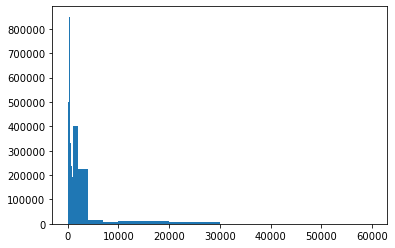

In [31]:
plt.figure()
plt.hist(sales.item_price, bins=[10,100,200,400,600, 800, 1000, 2000, 4000, 7000, 10000, 20000, 30000, 60000])
# plt.xlabel("Цена товаров")
plt.savefig("data/price.png")

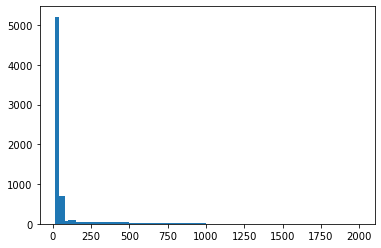

In [35]:
plt.figure()
plt.hist(sales.item_cnt_day, bins=[15, 40, 80, 100, 150, 500,1000, 1500, 2000])
# plt.xlabel("Количесвто проданных товаров")
plt.savefig("data/count.png")

**Preparing Sales Information**

In [14]:
#loading sales data
sales = pd.read_csv(path+'train.csv')
sales = (sales
    .query('0 < item_price < 50000 and 0 < item_cnt_day < 250') #removing outliers
    .replace({
        'shop_id':{0:57, 1:58, 11:10}, #replacing obsolete shop id's
        'item_id':item_map #fixing duplicate item id's  
    })    
)

#removing shops which don't appear in the test set
sales = sales[sales['shop_id'].isin(test.shop_id.unique())]

sales['date'] = pd.to_datetime(sales.date,format='%d.%m.%Y')
sales['weekday'] = sales.date.dt.dayofweek

#first day the item was sold, day 0 is the first day of the training set period
sales['first_sale_day'] = sales.date.dt.dayofyear 
sales['first_sale_day'] += 365 * (sales.date.dt.year-2013)
sales['first_sale_day'] = sales.groupby('item_id')['first_sale_day'].transform('min').astype('int16')

#revenue is needed to accurately calculate prices after grouping
sales['revenue'] = sales['item_cnt_day']*sales['item_price']

In [15]:
sales.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,first_sale_day,revenue
638884,2013-07-28,6,28,9565,99.0,1.0,6,2,99.0
2311904,2014-12-14,23,22,5380,3490.0,1.0,6,29,3490.0
2169718,2014-11-29,22,24,787,359.0,1.0,5,260,359.0
1689854,2014-05-04,16,44,4391,598.7,1.0,6,466,598.7
896758,2013-09-16,8,45,3739,299.0,1.0,0,81,299.0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,first_sale_day,revenue
638884,2013-07-28,6,28,9565,99.0,1.0,6,2,99.0
2311904,2014-12-14,23,22,5380,3490.0,1.0,6,29,3490.0
2169718,2014-11-29,22,24,787,359.0,1.0,5,260,359.0
1689854,2014-05-04,16,44,4391,598.7,1.0,6,466,598.7
896758,2013-09-16,8,45,3739,299.0,1.0,0,81,299.0


In [16]:
temp = sales.groupby(['shop_id','weekday']).agg({'item_cnt_day':'sum'}).reset_index()
temp = pd.merge(temp, sales.groupby(['shop_id']).agg({'item_cnt_day':'sum'}).reset_index(), on='shop_id', how='left')
temp.columns = ['shop_id','weekday', 'shop_day_sales', 'shop_total_sales']
temp['day_quality'] = temp['shop_day_sales']/temp['shop_total_sales']
temp = temp[['shop_id','weekday','day_quality']]

dates = pd.DataFrame(data={'date':pd.date_range(start='2013-01-01',end='2015-11-30')})
dates['weekday'] = dates.date.dt.dayofweek
dates['month'] = dates.date.dt.month
dates['year'] = dates.date.dt.year - 2013
dates['date_block_num'] = dates['year']*12 + dates['month'] - 1
dates['first_day_of_month'] = dates.date.dt.dayofyear
dates['first_day_of_month'] += 365 * dates['year']
dates = dates.join(temp.set_index('weekday'), on='weekday')
dates = dates.groupby(['date_block_num','shop_id','month','year']).agg({'day_quality':'sum','first_day_of_month':'min'}).reset_index()

dates.query('shop_id == 28').head(15)

,date_block_num,shop_id,month,year,day_quality,first_day_of_month
18,0,28,1,0,4.300037,1
60,1,28,2,0,4.000000,32
102,2,28,3,0,4.605952,60
144,3,28,4,0,4.193211,91
186,4,28,5,0,4.333970,121
228,5,28,6,0,4.472819,152
270,6,28,7,0,4.287644,182
312,7,28,8,0,4.492718,213
354,8,28,9,0,4.313648,244
396,9,28,10,0,4.300037,274


,date_block_num,shop_id,month,year,day_quality,first_day_of_month
18,0,28,1,0,4.300037,1
60,1,28,2,0,4.000000,32
102,2,28,3,0,4.605952,60
144,3,28,4,0,4.193211,91
186,4,28,5,0,4.333970,121
228,5,28,6,0,4.472819,152
270,6,28,7,0,4.287644,182
312,7,28,8,0,4.492718,213
354,8,28,9,0,4.313648,244
396,9,28,10,0,4.300037,274


Group the sales data by month, shop_id and item_id

In [17]:
sales = (sales
     .groupby(['date_block_num', 'shop_id', 'item_id'])
     .agg({
         'item_cnt_day':'sum', 
         'revenue':'sum',
         'first_sale_day':'first'
     })
     .reset_index()
     .rename(columns={'item_cnt_day':'item_cnt'})
)
sales.sample(5)

,date_block_num,shop_id,item_id,item_cnt,revenue,first_sale_day
750785,17,25,6317,1.0,58.00,6
155826,3,21,15836,2.0,298.00,2
31417,0,42,3429,7.0,19574.25,2
1041594,25,2,5901,2.0,5798.00,689
223408,4,56,6286,1.0,299.00,2


,date_block_num,shop_id,item_id,item_cnt,revenue,first_sale_day
750785,17,25,6317,1.0,58.00,6
155826,3,21,15836,2.0,298.00,2
31417,0,42,3429,7.0,19574.25,2
1041594,25,2,5901,2.0,5798.00,689
223408,4,56,6286,1.0,299.00,2


**Constructing Training Dataframe**

In [18]:
df = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]]))))

df = pd.DataFrame(np.vstack(df), columns=['shop_id', 'item_id', 'date_block_num'])
df.head()

,shop_id,item_id,date_block_num
0,2,27,0
1,2,33,0
2,2,317,0
3,2,438,0
4,2,473,0


,shop_id,item_id,date_block_num
0,2,27,0
1,2,33,0
2,2,317,0
3,2,438,0
4,2,473,0


In [19]:
#add the appropriate date_block_num value to the test set
test['date_block_num'] = 34
del test['ID']

In [20]:
#append test set to training dataframe
df = pd.concat([df,test]).fillna(0)
df = df.reset_index()
del df['index']

In [21]:
#join sales and item inforamtion to the training dataframe
df = pd.merge(df, sales, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)
df = pd.merge(df, dates, on=['date_block_num','shop_id'], how='left')
df = pd.merge(df, items.drop(columns=['item_name','group_name','item_category_name']), on='item_id', how='left')

In [22]:
df.head(15)

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,item_category_id,item_name_first4,item_name_first6,item_name_first11,group_id
0,2,27,0,1.0,2499.0,2.0,1,0,4.381749,1,19,1,1,1,5
1,2,33,0,1.0,499.0,2.0,1,0,4.381749,1,37,187,249,414,10
2,2,317,0,1.0,299.0,4.0,1,0,4.381749,1,45,33,38,52,11
3,2,438,0,1.0,299.0,19.0,1,0,4.381749,1,45,33,38,54,11
4,2,473,0,2.0,798.0,3.0,1,0,4.381749,1,49,35,43,59,11
5,2,481,0,1.0,330.0,2.0,1,0,4.381749,1,49,35,43,59,11
6,2,482,0,1.0,3300.0,4.0,1,0,4.381749,1,73,35,43,59,14
7,2,486,0,2.0,600.0,1.0,1,0,4.381749,1,73,35,43,59,14
8,2,491,0,1.0,600.0,3.0,1,0,4.381749,1,73,37,45,61,14
9,2,534,0,2.0,798.0,2.0,1,0,4.381749,1,77,43,52,69,14


,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,item_category_id,item_name_first4,item_name_first6,item_name_first11,group_id
0,2,27,0,1.0,2499.0,2.0,1,0,4.381749,1,19,1,1,1,5
1,2,33,0,1.0,499.0,2.0,1,0,4.381749,1,37,187,249,414,10
2,2,317,0,1.0,299.0,4.0,1,0,4.381749,1,45,33,38,52,11
3,2,438,0,1.0,299.0,19.0,1,0,4.381749,1,45,33,38,54,11
4,2,473,0,2.0,798.0,3.0,1,0,4.381749,1,49,35,43,59,11
5,2,481,0,1.0,330.0,2.0,1,0,4.381749,1,49,35,43,59,11
6,2,482,0,1.0,3300.0,4.0,1,0,4.381749,1,73,35,43,59,14
7,2,486,0,2.0,600.0,1.0,1,0,4.381749,1,73,35,43,59,14
8,2,491,0,1.0,600.0,3.0,1,0,4.381749,1,73,37,45,61,14
9,2,534,0,2.0,798.0,2.0,1,0,4.381749,1,77,43,52,69,14


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8756439 entries, 0 to 8756438
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   shop_id             int64  
 1   item_id             int64  
 2   date_block_num      int64  
 3   item_cnt            float64
 4   revenue             float64
 5   first_sale_day      float64
 6   month               int64  
 7   year                int64  
 8   day_quality         float64
 9   first_day_of_month  int64  
 10  item_category_id    int64  
 11  item_name_first4    int64  
 12  item_name_first6    int64  
 13  item_name_first11   int64  
 14  group_id            int64  
dtypes: float64(4), int64(11)
memory usage: 1.0 GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8756439 entries, 0 to 8756438
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   shop_id             int64  
 1   item_id             int64  
 2   date_block_num      int64

**Adding Shop Information**

In [4]:
shops = pd.read_csv(path+'shops.csv')
pd.DataFrame(categories.item_category_name.values.reshape(-1, 4))

In [24]:
#loading shops.csv
shops = pd.read_csv(path+'shops.csv')

#clustering shops
shops_cats = pd.DataFrame(
    np.array(list(product(*[df['shop_id'].unique(), df['item_category_id'].unique()]))),
    columns =['shop_id', 'item_category_id']
)

temp = df.groupby(['item_category_id', 'shop_id']).agg({'item_cnt':'sum'}).reset_index()
temp2 = temp.groupby('shop_id').agg({'item_cnt':'sum'}).rename(columns={'item_cnt':'shop_total'})
temp = temp.join(temp2, on='shop_id')
temp['category_proportion'] = temp['item_cnt']/temp['shop_total']
temp = temp[['shop_id', 'item_category_id', 'category_proportion']]

shops_cats = pd.merge(shops_cats, temp, on=['shop_id','item_category_id'], how='left')
shops_cats = shops_cats.fillna(0)

shops_cats = shops_cats.pivot(index='shop_id', columns='item_category_id')
kmeans = KMeans(n_clusters=7, random_state=0).fit(shops_cats)
shops_cats['shop_cluster'] = kmeans.labels_.astype('int8')

# #adding these clusters to the shops dataframe
shops = shops.join(shops_cats['shop_cluster'], on='shop_id')

In [25]:
#removing unused shop ids
shops.dropna(inplace=True)

#cleaning the name column
shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', ' ')

#creating a column for the type of shop
shops['shop_type'] = 'regular'

#there is some overlap in tc and mall, mall is given precedence
shops.loc[shops['shop_name'].str.contains(r'тц|тк'), 'shop_type'] = 'tc'
shops.loc[shops['shop_name'].str.contains(r'трц|трк|мега'), 'shop_type'] = 'mall'
shops.loc[shops['shop_id'].isin([9,20]), 'shop_type'] = 'special'
shops.loc[shops['shop_id'].isin([12,55]), 'shop_type'] = 'online'

#the first word of shop name is largely sufficient as a city feature
shops['shop_city'] = shops['shop_name'].str.split().str[0]
shops.loc[shops['shop_id'].isin([12,55]), 'shop_city'] = 'online'

#encode 'shop_city' and 'shop_type'
shops.shop_city = le.fit_transform(shops.shop_city.values)
shops.shop_type = le.fit_transform(shops.shop_type.values)

shops.head()

,shop_name,shop_id,shop_cluster,shop_type,shop_city
2,адыгея тц мега,2,4.0,0,1
3,балашиха трк октябрь киномир,3,0.0,0,2
4,волжский тц волга молл,4,0.0,3,3
5,вологда трц мармелад,5,0.0,0,4
6,воронеж плехановская 13,6,0.0,2,5


,shop_name,shop_id,shop_cluster,shop_type,shop_city
2,адыгея тц мега,2,4.0,0,1
3,балашиха трк октябрь киномир,3,0.0,0,2
4,волжский тц волга молл,4,0.0,3,3
5,вологда трц мармелад,5,0.0,0,4
6,воронеж плехановская 13,6,0.0,2,5


In [26]:
#add shop information to the training dataframe
df = pd.merge(df, shops.drop(columns='shop_name'), on='shop_id', how='left')
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,item_category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city
0,2,27,0,1.0,2499.0,2.0,1,0,4.381749,1,19,1,1,1,5,4.0,0,1
1,2,33,0,1.0,499.0,2.0,1,0,4.381749,1,37,187,249,414,10,4.0,0,1
2,2,317,0,1.0,299.0,4.0,1,0,4.381749,1,45,33,38,52,11,4.0,0,1
3,2,438,0,1.0,299.0,19.0,1,0,4.381749,1,45,33,38,54,11,4.0,0,1
4,2,473,0,2.0,798.0,3.0,1,0,4.381749,1,49,35,43,59,11,4.0,0,1


,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,first_day_of_month,item_category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city
0,2,27,0,1.0,2499.0,2.0,1,0,4.381749,1,19,1,1,1,5,4.0,0,1
1,2,33,0,1.0,499.0,2.0,1,0,4.381749,1,37,187,249,414,10,4.0,0,1
2,2,317,0,1.0,299.0,4.0,1,0,4.381749,1,45,33,38,52,11,4.0,0,1
3,2,438,0,1.0,299.0,19.0,1,0,4.381749,1,45,33,38,54,11,4.0,0,1
4,2,473,0,2.0,798.0,3.0,1,0,4.381749,1,49,35,43,59,11,4.0,0,1


**Ages & Aggregating Sales/Price information**

In [27]:
df['first_sale_day'] = df.groupby('item_id')['first_sale_day'].transform('max').astype('int16')
df.loc[df['first_sale_day']==0, 'first_sale_day'] = 1035
df['prev_days_on_sale'] = [max(idx) for idx in zip(df['first_day_of_month']-df['first_sale_day']-1,[0]*len(df))]
del df['first_day_of_month']

In [28]:
#freeing RAM, removing unneeded columns and encoding object columns
del sales, categories, shops, shops_cats, temp, temp2, test, dupes, item_map, 
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,item_category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city,prev_days_on_sale
0,2,27,0,1.0,2499.0,2,1,0,4.381749,19,1,1,1,5,4.0,0,1,0
1,2,33,0,1.0,499.0,2,1,0,4.381749,37,187,249,414,10,4.0,0,1,0
2,2,317,0,1.0,299.0,4,1,0,4.381749,45,33,38,52,11,4.0,0,1,0
3,2,438,0,1.0,299.0,19,1,0,4.381749,45,33,38,54,11,4.0,0,1,0
4,2,473,0,2.0,798.0,3,1,0,4.381749,49,35,43,59,11,4.0,0,1,0


,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,item_category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city,prev_days_on_sale
0,2,27,0,1.0,2499.0,2,1,0,4.381749,19,1,1,1,5,4.0,0,1,0
1,2,33,0,1.0,499.0,2,1,0,4.381749,37,187,249,414,10,4.0,0,1,0
2,2,317,0,1.0,299.0,4,1,0,4.381749,45,33,38,52,11,4.0,0,1,0
3,2,438,0,1.0,299.0,19,1,0,4.381749,45,33,38,54,11,4.0,0,1,0
4,2,473,0,2.0,798.0,3,1,0,4.381749,49,35,43,59,11,4.0,0,1,0


In [29]:
df['item_cnt_unclipped'] = df['item_cnt']
df['item_cnt'] = df['item_cnt'].clip(0, 20)

In [30]:
def downcast(df):
    #reduce size of the dataframe
    float_cols = [c for c in df if df[c].dtype in ["float64"]]
    int_cols = [c for c in df if df[c].dtype in ['int64']]
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int16')
    return df
df = downcast(df)

In [31]:
df['item_age'] = (df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')).astype('int8')
df['item_name_first4_age'] = (df['date_block_num'] - df.groupby('item_name_first4')['date_block_num'].transform('min')).astype('int8')
df['item_name_first6_age'] = (df['date_block_num'] - df.groupby('item_name_first6')['date_block_num'].transform('min')).astype('int8')
df['item_name_first11_age'] = (df['date_block_num'] - df.groupby('item_name_first11')['date_block_num'].transform('min')).astype('int8')
df['category_age'] = (df['date_block_num'] - df.groupby('item_category_id')['date_block_num'].transform('min')).astype('int8')
df['group_age'] = (df['date_block_num'] - df.groupby('group_id')['date_block_num'].transform('min')).astype('int8')
df['shop_age'] = (df['date_block_num'] - df.groupby('shop_id')['date_block_num'].transform('min')).astype('int8')

In [32]:
#indicates whether shops have previously sold the item
temp = df.query('item_cnt > 0').groupby(['item_id','shop_id']).agg({'date_block_num':'min'}).reset_index()
temp.columns = ['item_id', 'shop_id', 'item_shop_first_sale']
df = pd.merge(df, temp, on=['item_id','shop_id'], how='left')
df['item_shop_first_sale'] = df['item_shop_first_sale'].fillna(50)
#item age that stays at 0 if a shop hasn't sold the item
df['item_age_if_shop_sale'] = (df['date_block_num'] > df['item_shop_first_sale']) * df['item_age']
#the length of time an item has been for sale without being sold at individual shops
df['item_age_without_shop_sale'] = (df['date_block_num'] <= df['item_shop_first_sale']) * df['item_age']
del df['item_shop_first_sale']

In [33]:
def agg_cnt_col(df, merging_cols, new_col, aggregation):
    temp = df.groupby(merging_cols).agg(aggregation).reset_index()
    temp.columns = merging_cols + [new_col]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#individual items across all shops
df = agg_cnt_col(df, ['date_block_num','item_id'],'item_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','item_category_id','shop_id'],'item_cnt_all_shops_median',{'item_cnt':'median'}) 

# по-моему так будет лучше
# df = agg_cnt_col(df, ['date_block_num','item_id'],'item_cnt_all_shops_median',{'item_cnt':'median'}) 

#all items in category at individual shops
df = agg_cnt_col(df, ['date_block_num','item_category_id','shop_id'],'category_cnt',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','item_category_id','shop_id'],'category_cnt_median',{'item_cnt':'median'}) 
#all items in category across all shops
df = agg_cnt_col(df, ['date_block_num','item_category_id'],'category_cnt_all_shops',{'item_cnt':'mean'})
df = agg_cnt_col(df, ['date_block_num','item_category_id'],'category_cnt_all_shops_median',{'item_cnt':'median'})
#all items in group
df = agg_cnt_col(df, ['date_block_num','group_id','shop_id'],'group_cnt',{'item_cnt':'mean'})
#all items in group across all shops
df = agg_cnt_col(df, ['date_block_num','group_id'],'group_cnt_all_shops',{'item_cnt':'mean'})
#all items at individual shops
df = agg_cnt_col(df, ['date_block_num','shop_id'],'shop_cnt',{'item_cnt':'mean'})
#all items at all shops within the city
df = agg_cnt_col(df, ['date_block_num','shop_city'],'city_cnt',{'item_cnt':'mean'})

In [34]:
df.head()

,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,item_category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city,prev_days_on_sale,item_cnt_unclipped,item_age,item_name_first4_age,item_name_first6_age,item_name_first11_age,category_age,group_age,shop_age,item_age_if_shop_sale,item_age_without_shop_sale,item_cnt_all_shops,item_cnt_all_shops_median,category_cnt,category_cnt_median,category_cnt_all_shops,category_cnt_all_shops_median,group_cnt,group_cnt_all_shops,shop_cnt,city_cnt
0,2,27,0,1.0,2499.0,2,1,0,4.38175,19,1,1,1,5,4.0,0,1,0,1.0,0,0,0,0,0,0,0,0,0,0.200000,0.0,0.506667,0.0,0.865905,0.0,0.451493,0.770309,0.152754,0.152754
1,2,33,0,1.0,499.0,2,1,0,4.38175,37,187,249,414,10,4.0,0,1,0,1.0,0,0,0,0,0,0,0,0,0,1.285714,0.0,0.084691,0.0,0.209121,0.0,0.079820,0.284362,0.152754,0.152754
2,2,317,0,1.0,299.0,4,1,0,4.38175,45,33,38,52,11,4.0,0,1,0,1.0,0,0,0,0,0,0,0,0,0,0.057143,0.0,0.031250,0.0,0.095536,0.0,0.063232,0.129475,0.152754,0.152754
3,2,438,0,1.0,299.0,19,1,0,4.38175,45,33,38,54,11,4.0,0,1,0,1.0,0,0,0,0,0,0,0,0,0,0.085714,0.0,0.031250,0.0,0.095536,0.0,0.063232,0.129475,0.152754,0.152754
4,2,473,0,2.0,798.0,3,1,0,4.38175,49,35,43,59,11,4.0,0,1,0,2.0,0,0,0,0,0,0,0,0,0,0.742857,0.0,0.093023,0.0,0.268106,0.0,0.063232,0.129475,0.152754,0.152754


,shop_id,item_id,date_block_num,item_cnt,revenue,first_sale_day,month,year,day_quality,item_category_id,item_name_first4,item_name_first6,item_name_first11,group_id,shop_cluster,shop_type,shop_city,prev_days_on_sale,item_cnt_unclipped,item_age,item_name_first4_age,item_name_first6_age,item_name_first11_age,category_age,group_age,shop_age,item_age_if_shop_sale,item_age_without_shop_sale,item_cnt_all_shops,item_cnt_all_shops_median,category_cnt,category_cnt_median,category_cnt_all_shops,category_cnt_all_shops_median,group_cnt,group_cnt_all_shops,shop_cnt,city_cnt
0,2,27,0,1.0,2499.0,2,1,0,4.38175,19,1,1,1,5,4.0,0,1,0,1.0,0,0,0,0,0,0,0,0,0,0.200000,0.0,0.506667,0.0,0.865905,0.0,0.451493,0.770309,0.152754,0.152754
1,2,33,0,1.0,499.0,2,1,0,4.38175,37,187,249,414,10,4.0,0,1,0,1.0,0,0,0,0,0,0,0,0,0,1.285714,0.0,0.084691,0.0,0.209121,0.0,0.079820,0.284362,0.152754,0.152754
2,2,317,0,1.0,299.0,4,1,0,4.38175,45,33,38,52,11,4.0,0,1,0,1.0,0,0,0,0,0,0,0,0,0,0.057143,0.0,0.031250,0.0,0.095536,0.0,0.063232,0.129475,0.152754,0.152754
3,2,438,0,1.0,299.0,19,1,0,4.38175,45,33,38,54,11,4.0,0,1,0,1.0,0,0,0,0,0,0,0,0,0,0.085714,0.0,0.031250,0.0,0.095536,0.0,0.063232,0.129475,0.152754,0.152754
4,2,473,0,2.0,798.0,3,1,0,4.38175,49,35,43,59,11,4.0,0,1,0,2.0,0,0,0,0,0,0,0,0,0,0.742857,0.0,0.093023,0.0,0.268106,0.0,0.063232,0.129475,0.152754,0.152754


Create features showing the mean first month sales for items in each category

In [35]:
def new_item_sales(df, merging_cols, new_col):
    temp = (
        df
        .query('item_age==0')
        .groupby(merging_cols)['item_cnt']
        .mean()
        .reset_index()
        .rename(columns={'item_cnt': new_col})
    )
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#mean units sold of new item in category at individual shop
df = new_item_sales(df, ['date_block_num','item_category_id','shop_id'], 'new_items_in_cat')
#mean units sold of new item in category across all shops
df = new_item_sales(df, ['date_block_num','item_category_id'], 'new_items_in_cat_all_shops')

In [36]:
def agg_price_col(df, merging_cols, new_col):
    temp = df.groupby(merging_cols).agg({'revenue':'sum','item_cnt_unclipped':'sum'}).reset_index()
    temp[new_col] = temp['revenue']/temp['item_cnt_unclipped']
    temp = temp[merging_cols + [new_col]]
    df = pd.merge(df, temp, on=merging_cols, how='left')
    return df

#average item price
df = agg_price_col(df,['date_block_num','item_id'],'item_price')
#average price of items in category
df = agg_price_col(df,['date_block_num','item_category_id'],'category_price')
#average price of all items
df = agg_price_col(df,['date_block_num'],'block_price')

In [37]:
df = downcast(df)

**Lagging Values & Features that use Prior Information**

In [38]:
def lag_feature(df, lag, col, merge_cols):        
    temp = df[merge_cols + [col]]
    temp = temp.groupby(merge_cols).agg({f'{col}':'first'}).reset_index()
    temp.columns = merge_cols + [f'{col}_lag{lag}']
    temp['date_block_num'] += lag
    df = pd.merge(df, temp, on=merge_cols, how='left')
    df[f'{col}_lag{lag}'] = df[f'{col}_lag{lag}'].fillna(0).astype('float32')
    return df

These features each have 3 lagged columns returned:
* lag1 shows the value of the prior month
* lag2 shows the value two months prior
* lag1to12 is the sum of values across the previous 12 months

In [40]:
lag12_cols = {
    'item_cnt':['date_block_num', 'shop_id', 'item_id'],
    'item_cnt_all_shops':['date_block_num', 'item_id'],
    'category_cnt':['date_block_num', 'shop_id', 'item_category_id'],
    'category_cnt_all_shops':['date_block_num', 'item_category_id'],
    'group_cnt':['date_block_num', 'shop_id', 'group_id'],
    'group_cnt_all_shops':['date_block_num', 'group_id'],
    'shop_cnt':['date_block_num', 'shop_id'],
    'city_cnt':['date_block_num', 'shop_city'],
    'new_items_in_cat':['date_block_num', 'shop_id', 'item_category_id'],
    'new_items_in_cat_all_shops':['date_block_num', 'item_category_id']
}
for col, merge_cols in lag12_cols.items():
    df[f'{col}_lag1to12'] = 0
    for i in range(1,13):
        df = lag_feature(df, i, col, merge_cols)
        df[f'{col}_lag1to12'] += df[f'{col}_lag{i}']
        if i > 2:
            del df[f'{col}_lag{i}']
    if col == 'item_cnt':
        del df[f'{col}_lag1']
        del df[f'{col}_lag2']        
    else:
        del df[col]

In [45]:
lag2_cols = {
    'item_cnt_unclipped':['date_block_num', 'shop_id', 'item_id'],
    'item_cnt_all_shops_median':['date_block_num', 'item_id'],
    'category_cnt_median':['date_block_num', 'shop_id', 'item_category_id'],
    'category_cnt_all_shops_median':['date_block_num', 'item_category_id']
}
for col in lag2_cols:
    df = lag_feature(df, 1, col, merge_cols)
    df = lag_feature(df, 2, col, merge_cols)
    if col!='item_cnt_unclipped':
        del df[col]

In [46]:
df['item_cnt_diff'] = df['item_cnt_unclipped_lag1']/df['item_cnt_lag1to12']
df['item_cnt_all_shops_diff'] = df['item_cnt_all_shops_lag1']/df['item_cnt_all_shops_lag1to12']
df['category_cnt_diff'] = df['category_cnt_lag1']/df['category_cnt_lag1to12']
df['category_cnt_all_shops_diff'] = df['category_cnt_all_shops_lag1']/df['category_cnt_all_shops_lag1to12']

In [47]:
df = lag_feature(df, 1, 'category_price',['date_block_num', 'item_category_id'])
df = lag_feature(df, 1, 'block_price',['date_block_num'])
del df['category_price'], df['block_price']

In [48]:
df.loc[(df['item_age']>0) & (df['item_cnt_lag1to12'].isna()), 'item_cnt_lag1to12'] = 0
df.loc[(df['category_age']>0) & (df['category_cnt_lag1to12'].isna()), 'category_cnt_lag1to12'] = 0
df.loc[(df['group_age']>0) & (df['group_cnt_lag1to12'].isna()), 'group_cnt_lag1to12'] = 0

In [49]:
df['item_cnt_lag1to12'] /= [min(idx) for idx in zip(df['item_age'],df['shop_age'],[12]*len(df))]
df['item_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['item_age'],[12]*len(df))]
df['category_cnt_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[12]*len(df))]
df['category_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],[12]*len(df))]
df['group_cnt_lag1to12'] /= [min(idx) for idx in zip(df['group_age'],df['shop_age'],[12]*len(df))]
df['group_cnt_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['group_age'],[12]*len(df))]
df['city_cnt_lag1to12'] /= [min(idx) for idx in zip(df['date_block_num'],[12]*len(df))]
df['shop_cnt_lag1to12'] /= [min(idx) for idx in zip(df['shop_age'],[12]*len(df))]
df['new_items_in_cat_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],df['shop_age'],[12]*len(df))]
df['new_items_in_cat_all_shops_lag1to12'] /= [min(idx) for idx in zip(df['category_age'],[12]*len(df))]

In [50]:
df = downcast(df)

In [51]:
def past_information(df, merging_cols, new_col, aggregation):
    temp = []
    for i in range(1,35):
        block = df.query(f'date_block_num < {i}').groupby(merging_cols).agg(aggregation).reset_index()
        block.columns = merging_cols + [new_col]
        block['date_block_num'] = i
        block = block[block[new_col]>0]
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=['date_block_num']+merging_cols, how='left')
    return df

#average item price in latest block item was sold
df = past_information(df, ['item_id'],'last_item_price',{'item_price':'last'})
#total units of item sold at individual shop
df = past_information(df, ['shop_id','item_id'],'item_cnt_sum_alltime',{'item_cnt':'sum'})
#total units of item sold at all shops
df = past_information(df, ['item_id'],'item_cnt_sum_alltime_allshops',{'item_cnt':'sum'})

#these columns are no longer needed, and would cause data leakage if retained
del df['revenue'], df['item_cnt_unclipped'], df['item_price']

In [52]:
df['relative_price_item_block_lag1'] = df['last_item_price']/df['block_price_lag1']

In [53]:
df['item_cnt_per_day_alltime'] = (df['item_cnt_sum_alltime']/df['prev_days_on_sale']).fillna(0)
df['item_cnt_per_day_alltime_allshops'] = (df['item_cnt_sum_alltime_allshops']/df['prev_days_on_sale']).fillna(0)

In [54]:
import gc
gc.collect()
df = downcast(df)

In [55]:
def matching_name_cat_age(df, n, all_shops):
    temp_cols = [f'same_name{n}catage_cnt','date_block_num', f'item_name_first{n}','item_age','item_category_id']
    if all_shops:
        temp_cols[0] += '_all_shops'
    else:
        temp_cols += ['shop_id']
    temp = []
    for i in range(1,35):
        block = (
            df
            .query(f'date_block_num < {i}')
            .groupby(temp_cols[2:])
            .agg({'item_cnt':'mean'})
            .reset_index()
            .rename(columns={'item_cnt':temp_cols[0]})
        )
        block = block[block[temp_cols[0]]>0]
        block['date_block_num'] = i
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on=temp_cols[1:], how='left')
    return df

for n in [4,6,11]:
    for all_shops in [True,False]:
        df = matching_name_cat_age(df,n,all_shops)

In [56]:
#assign appropriate datatypes
df = downcast(df)
int8_cols = [
    'item_cnt','month','group_id','shop_type',
    'shop_city','shop_id','date_block_num','item_category_id',
    'item_age',
]
int16_cols = [
    'item_id','item_name_first4',
    'item_name_first6','item_name_first11'
]
for col in int8_cols:
    df[col] = df[col].astype('int8')
for col in int16_cols:
    df[col] = df[col].astype('int16')

In [57]:
def nearby_item_data(df,col):
    if col in ['item_cnt_unclipped_lag1','item_cnt_lag1to12']:
        cols = ['date_block_num', 'shop_id', 'item_id']
        temp = df[cols + [col]] 
    else:
        cols = ['date_block_num', 'item_id']
        temp = df.groupby(cols).agg({col:'first'}).reset_index()[cols + [col]]   
    
    temp.columns = cols + [f'below_{col}']
    temp['item_id'] += 1
    df = pd.merge(df, temp, on=cols, how='left')
    
    temp.columns = cols + [f'above_{col}']
    temp['item_id'] -= 2
    df = pd.merge(df, temp, on=cols, how='left')
    
    return df

item_cols = ['item_cnt_unclipped_lag1','item_cnt_lag1to12',
             'item_cnt_all_shops_lag1','item_cnt_all_shops_lag1to12']
for col in item_cols:
    df = nearby_item_data(df,col)
    
del temp

**Encoding Name Information**

In [58]:
results = Counter()
items['item_name'].str.split().apply(results.update)

words = []
cnts = []
for key, value in results.items():
    words.append(key)
    cnts.append(value)
    
counts = pd.DataFrame({'word':words,'count':cnts})
common_words = counts.query('count>200').word.to_list()
for word in common_words:
    items[f'{word}_in_name'] = items['item_name'].str.contains(word).astype('int8')
drop_cols = [
    'item_id','item_category_id','item_name','item_name_first4',
    'item_name_first6','item_name_first11',
    'item_category_name','group_name','group_id'
]
items = items.drop(columns=drop_cols)

In [59]:
#join these word vectors to the training dataframe
df = df.join(items, on='item_id')

In [60]:
def binary_encode(df, letters, cols):
    encoder = ce.BinaryEncoder(cols=[f'item_name_first{letters}'], return_df=True)
    temp = encoder.fit_transform(df[f'item_name_first{letters}'])
    df = pd.concat([df,temp], axis=1)
    del df[f'item_name_first{letters}_0']
    name_cols = [f'item_name_first{letters}_{x}' for x in range(1,cols)]
    df[name_cols] = df[name_cols].astype('int8')
    return df

df = binary_encode(df, 11, 15)
    
del df['item_name_first4'], df['item_name_first6']

In [48]:
#save dataframe for later use
df.to_pickle(path+'df_complete.pkl', protocol=4)

In [76]:
pd.DataFrame(np.array(df.columns).reshape(-1, 3))

,0,1,2
0,shop_id,item_id,date_block_num
1,item_cnt,first_sale_day,month
2,year,day_quality,item_category_id
3,item_name_first11,group_id,shop_cluster
4,shop_type,shop_city,prev_days_on_sale
5,item_age,item_name_first4_age,item_name_first6_age
6,item_name_first11_age,category_age,group_age
7,shop_age,item_age_if_shop_sale,item_age_without_shop_sale
8,item_cnt_lag1to12,item_cnt_all_shops_lag1to12,item_cnt_all_shops_lag1
9,item_cnt_all_shops_lag2,category_cnt_lag1to12,category_cnt_lag1


,0,1,2
0,shop_id,item_id,date_block_num
1,item_cnt,first_sale_day,month
2,year,day_quality,item_category_id
3,item_name_first11,group_id,shop_cluster
4,shop_type,shop_city,prev_days_on_sale
5,item_age,item_name_first4_age,item_name_first6_age
6,item_name_first11_age,category_age,group_age
7,shop_age,item_age_if_shop_sale,item_age_without_shop_sale
8,item_cnt_lag1to12,item_cnt_all_shops_lag1to12,item_cnt_all_shops_lag1
9,item_cnt_all_shops_lag2,category_cnt_lag1to12,category_cnt_lag1
